# # Exercise 1.1

## Classification of MNIST digits with a fully-connected neural network

In this exercise we will classify [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) using a fully-connected neural network

We start by importing the modules that we need

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


We check that we have a GPU available

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


The MNIST dataset is a built-in dataset in PyTorch (it is a very common dataset to test algorithms on). 

We import it, and set our minibatch size

In [3]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

First, we plot the images to get an idea of what data we're working with. MNIST images are $28\times28$ images of handwritten digits (0-9)

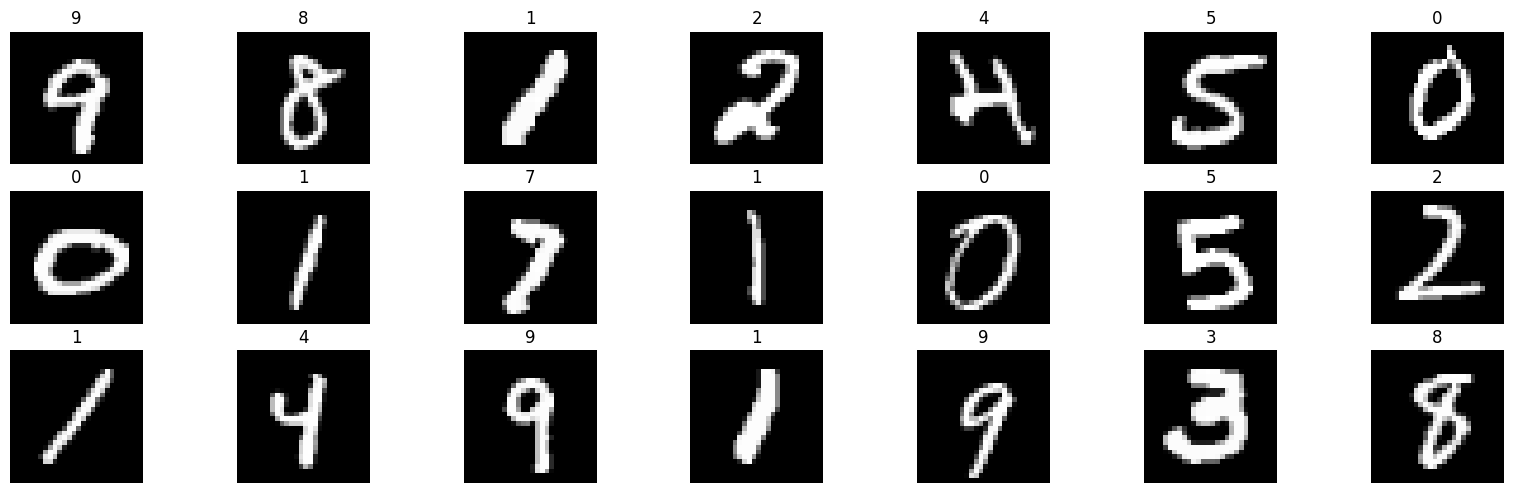

In [4]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

You should implement a fully-connected network to classify the digits. It should contain 1 hidden layer with 100 units. Don't forget the ReLU activation function after the hidden layer. 

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.Linear(28*28,200),
            nn.ReLU()
            )
        
        self.fully_connected2 = nn.Sequential(
            nn.Linear(200,100),
            nn.ReLU()
            )

        self.fully_connected3 = nn.Sequential(
            nn.Linear(100,10),
            nn.Softmax(dim = 1)
            )
        
    def forward(self, x):
      #reshaping x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0),-1)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        x = self.fully_connected3(x)
        return x

We instantiate a copy of our network and transfer it to the GPU if it's available

In [6]:
model = Network()
model.to(device)
#Initialize the optimer
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

In [7]:
@torch.no_grad()
def preview_batch(model, loader, device, n=16, title="Validation preview"):
    """Show n samples with predicted probs and ground truth; green=correct, red=wrong."""
    model.eval()
    x, y = next(iter(loader))                 # one batch
    x, y = x.to(device), y.to(device)
    logits = model(x)
    # If your model ends with LogSoftmax, use: probs = logits.exp()
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)

    n = min(n, x.size(0))
    cols = min(8, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.0, rows*2.2))
    axes = np.atleast_1d(axes).reshape(rows, cols)
    fig.suptitle(title, y=1.02, fontsize=12)

    for i in range(n):
        ax = axes[i // cols, i % cols]
        ax.imshow(x[i].detach().cpu().squeeze(), cmap="gray")
        ok = (pred[i] == y[i]).item()
        ax.set_title(
            f"pred {pred[i].item()} ({conf[i].item():.2f})\ntrue {y[i].item()}",
            color=("tab:green" if ok else "tab:red"),
            fontsize=9
        )
        ax.axis("off")
    for j in range(n, rows*cols):
        axes[j // cols, j % cols].axis("off")
    plt.tight_layout()
    plt.show()

    # Small textual readout of top-3 probabilities for the first few samples
    for i in range(min(5, n)):
        p = probs[i].detach().cpu().numpy()
        top3 = p.argsort()[-3:][::-1]
        print(f"#{i}: true={y[i].item()}  pred={pred[i].item()}  "
              f"conf={p[pred[i].item()]:.3f}  top3={[ (int(k), float(p[k])) for k in top3 ]}")

@torch.no_grad()
def show_most_confident_mistakes(model, loader, device, k=8):
    """Show the k most confident *wrong* predictions encountered in loader."""
    model.eval()
    wrong_imgs, wrong_y, wrong_pred, wrong_conf = [], [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        probs = F.softmax(model(x), dim=1)
        conf, pred = probs.max(1)
        wrong = pred.ne(y)
        if wrong.any():
            idx = wrong.nonzero(as_tuple=False).squeeze(1)
            # sort these wrong ones by confidence (desc)
            order = conf[idx].argsort(descending=True)
            idx = idx[order]
            wrong_imgs.append(x[idx].detach().cpu())
            wrong_y.append(y[idx].detach().cpu())
            wrong_pred.append(pred[idx].detach().cpu())
            wrong_conf.append(conf[idx].detach().cpu())
        if sum(t.size(0) for t in wrong_imgs) >= k:
            break

    if not wrong_imgs:
        print("No mistakes found in the scanned batches ✨")
        return

    X = torch.cat(wrong_imgs)[:k]
    Y = torch.cat(wrong_y)[:k]
    P = torch.cat(wrong_pred)[:k]
    C = torch.cat(wrong_conf)[:k]

    cols = min(8, k)
    rows = int(np.ceil(k / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.0, rows*2.2))
    axes = np.atleast_1d(axes).reshape(rows, cols)
    fig.suptitle("Most confident mistakes", y=1.02, fontsize=12)

    for i in range(X.size(0)):
        ax = axes[i // cols, i % cols]
        ax.imshow(X[i].squeeze(), cmap="gray")
        ax.set_title(f"pred {P[i].item()} ({C[i].item():.2f})\ntrue {Y[i].item()}",
                     color="tab:red", fontsize=9)
        ax.axis("off")
    for j in range(X.size(0), rows*cols):
        axes[j // cols, j % cols].axis("off")
    plt.tight_layout()
    plt.show()

We train the network for five epochs

In [9]:
num_epochs = 5
target_not_correct = {}
for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    target_not_correct = {}
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    # show_most_confident_mistakes(model, test_loader, device, k=100)

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 97.9%	 test: 97.3%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 98.3%	 test: 97.7%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 98.7%	 test: 97.8%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 99.0%	 test: 97.8%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 99.2%	 test: 96.7%


You should now have a model that has about 96% accuracy on the test set.
Try to get an even better accuracy. You can
* Change the number of hidden layers
* Change the number of units in the hidden layers
* Try changing the learning rate by factors of 10. What happens if it is too high or too low?
* Try using sigmoid instead of ReLU activation. What happens?

How large accuracy can you get? I got 98.7%

Try showing the classification output (probabilities) from the model alongside the ground truth.

* Which are classified correctly/incorrectly? 
* If it's incorrect, what is the second most likely class?
* Do the misclassifications you see make sense? Why/why not?